## Bước 1: Import modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import AdamW

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Bước 2: Dataset Class

In [6]:
# Dataset class cho Transformer
class NERTransformerDataset(Dataset):
    def __init__(self, sentences, tags, tokenizer, tag_to_idx, max_length=128):
        self.sentences = sentences
        self.tags = tags
        self.tokenizer = tokenizer
        self.tag_to_idx = tag_to_idx
        self.max_length = max_length
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]
        
        # Tokenize - với subword tokenization, cần align tags
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Align tags với subword tokens
        word_ids = encoding.word_ids(batch_index=0)
        aligned_tags = []
        previous_word_idx = None
        
        # Padding label id (standard trong transformers: -100 để ignore trong loss)
        pad_token_label_id = -100
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (CLS, SEP, PAD) - ignore trong loss
                aligned_tags.append(pad_token_label_id)
            elif word_idx != previous_word_idx:
                # First subword token của một word - dùng tag của word đó
                aligned_tags.append(self.tag_to_idx[tags[word_idx]])
            else:
                # Subword token tiếp theo - giữ nguyên tag của word
                aligned_tags.append(self.tag_to_idx[tags[word_idx]])
            previous_word_idx = word_idx
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(aligned_tags, dtype=torch.long)
        }

## Bước 3: Load và xử lý dữ liệu NER cho tiếng Việt (PhoNER)

In [8]:
def load_phoner_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load train, dev, test data
train_data = load_phoner_data('/kaggle/input/ner-vi/train_word.json')
dev_data = load_phoner_data('/kaggle/input/ner-vi/dev_word.json')
test_data = load_phoner_data('/kaggle/input/ner-vi/test_word.json')

# Extract sentences and tags
train_sentences = []
train_tags = []
for item in train_data:
    train_sentences.append(item['words'])
    train_tags.append(item['tags'])

val_sentences = []
val_tags = []
for item in dev_data:
    val_sentences.append(item['words'])
    val_tags.append(item['tags'])

test_sentences = []
test_tags = []
for item in test_data:
    test_sentences.append(item['words'])
    test_tags.append(item['tags'])

# Tạo tag mappings (chỉ dựa trên training data)
unique_tags = set()
for tag_list in train_tags:
    unique_tags.update(tag_list)

tag_to_idx = {}
for idx, tag in enumerate(sorted(unique_tags)):
    tag_to_idx[tag] = idx

idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}

print("NER_VI DATASET")
print("=" * 70)
print(f"Train sentences: {len(train_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")
print(f"Test sentences: {len(test_sentences)}")
print(f"Số lượng tags: {len(tag_to_idx)}")
print(f"Tags: {list(tag_to_idx.keys())}")
print(f"\nVí dụ câu đầu tiên:")
print(f"Words: {train_sentences[0]}")
print(f"Tags: {train_tags[0]}")

NER_VI DATASET
Train sentences: 5027
Validation sentences: 2000
Test sentences: 3000
Số lượng tags: 20
Tags: ['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 'I-AGE', 'I-DATE', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O']

Ví dụ câu đầu tiên:
Words: ['Đồng_thời', ',', 'bệnh_viện', 'tiếp_tục', 'thực_hiện', 'các', 'biện_pháp', 'phòng_chống', 'dịch_bệnh', 'COVID', '-', '19', 'theo', 'hướng_dẫn', 'của', 'Bộ', 'Y_tế', '.']
Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORGANIZATION', 'I-ORGANIZATION', 'O']


## Bước 4: Chuẩn bị dữ liệu và khởi tạo Model

In [ ]:
# Config - XLM-RoBERTa hỗ trợ cả tiếng Anh và tiếng Việt
model_name = 'xlm-roberta-base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Tokenizer và Model
tokenizer = AutoTokenizer.from_pretrained(model_name)
num_labels = len(tag_to_idx)
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)
model = model.to(device)

# Create datasets
max_length = 128
train_dataset = NERTransformerDataset(train_sentences, train_tags, tokenizer, tag_to_idx, max_length)
val_dataset = NERTransformerDataset(val_sentences, val_tags, tokenizer, tag_to_idx, max_length)
test_dataset = NERTransformerDataset(test_sentences, test_tags, tokenizer, tag_to_idx, max_length)

# DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTrain size: {len(train_sentences)}")
print(f"Val size: {len(val_sentences)}")
print(f"Test size: {len(test_sentences)}")
print(f"Number of labels: {num_labels}")

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-12-11 15:45:31.549266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765467931.738220      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765467931.792159      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]


Train size: 5027
Val size: 2000
Test size: 3000
Number of labels: 20


## Bước 5: Huấn luyện Model

In [ ]:
# Training setup
optimizer = AdamW(model.parameters(), lr=2e-5)

num_epochs = 5
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

print(f"\n{'='*70}")
print("TRAINING XLM-ROBERTA MODEL CHO NER_VI")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # TRAIN
    model.train()
    train_loss = 0
    train_batches = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        # Model tự tính loss khi có labels
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    

    # VALIDATION
    model.eval()
    val_loss = 0
    val_batches = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            
            val_loss += loss.item()
            val_batches += 1
            
            preds = torch.argmax(logits, dim=-1)  
            
            # Chỉ lấy token không phải padding (-100)
            mask = (labels != -100)
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_ner_model_vi.pth')
        print(f"Epoch {epoch+1}/{num_epochs} - Best model saved!")
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}\n")


TRAINING TRANSFORMER MODEL CHO NER_EN



Epoch 1/5 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.16it/s]


Epoch 1/5 - Best model saved!
Epoch 1/5
Train Loss: 0.6925 | Val Loss: 0.2753 | Val Acc: 0.9165



Epoch 2/5 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.23it/s]


Epoch 2/5 - Best model saved!
Epoch 2/5
Train Loss: 0.2170 | Val Loss: 0.1644 | Val Acc: 0.9520



Epoch 3/5 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.16it/s]


Epoch 3/5 - Best model saved!
Epoch 3/5
Train Loss: 0.1429 | Val Loss: 0.1178 | Val Acc: 0.9681



Epoch 4/5 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.20it/s]


Epoch 4/5 - Best model saved!
Epoch 4/5
Train Loss: 0.1087 | Val Loss: 0.1168 | Val Acc: 0.9683



Epoch 5/5 [Val]: 100%|██████████| 125/125 [00:07<00:00, 16.24it/s]


Epoch 5/5 - Best model saved!
Epoch 5/5
Train Loss: 0.0925 | Val Loss: 0.1046 | Val Acc: 0.9717



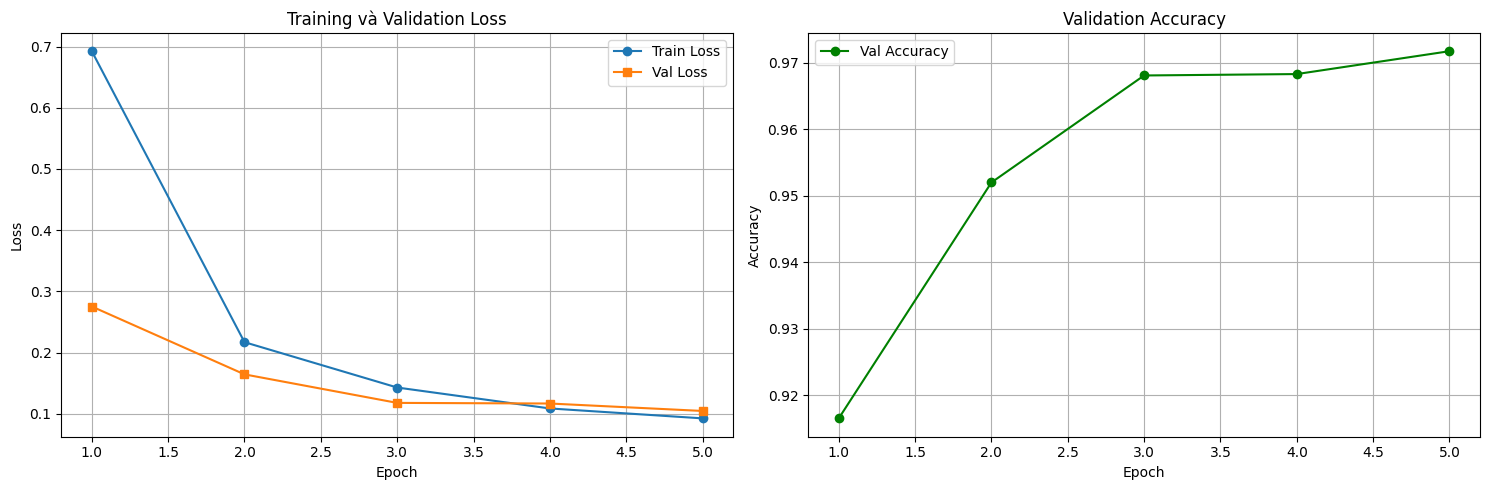

In [12]:
# Visualization: Loss và Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(range(1, num_epochs+1), train_losses, label='Train Loss', marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training và Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy', marker='o', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Bước 6: Đánh giá mô hình

In [ ]:
# Evaluation trên test set
model.load_state_dict(torch.load('best_transformer_ner_model_vi.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        # Only collect non-padding tokens (ignore -100)
        mask = (labels != -100)
        all_preds.extend(preds[mask].cpu().numpy())
        all_labels.extend(labels[mask].cpu().numpy())

Evaluating: 100%|██████████| 188/188 [00:11<00:00, 16.59it/s]


In [16]:
# Tính metrics
accuracy_micro = accuracy_score(all_labels, all_preds)
f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# Tính cho từng tag
tag_names = [idx_to_tag[i] for i in range(num_labels)]
tag_accuracies = []
tag_f1_scores = []

for tag_idx in range(num_labels):
    tag_mask = [label == tag_idx for label in all_labels]
    num_tag_samples = sum(tag_mask)
    
    if num_tag_samples > 0:
        correct = sum([all_labels[i] == all_preds[i] for i in range(len(all_labels)) if tag_mask[i]])
        tag_acc = correct / num_tag_samples
        
        binary_labels = [1 if label == tag_idx else 0 for label in all_labels]
        binary_preds = [1 if pred == tag_idx else 0 for pred in all_preds]
        tag_f1 = f1_score(binary_labels, binary_preds, zero_division=0)
    else:
        tag_acc = 0.0
        tag_f1 = 0.0
    
    tag_accuracies.append(tag_acc)
    tag_f1_scores.append(tag_f1)

accuracy_macro = np.mean(tag_accuracies)

# Kết quả
print("=" * 70)
print("KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP")
print("=" * 70)
print(f"Accuracy (Micro): {accuracy_micro:.4f}")
print(f"Accuracy (Macro): {accuracy_macro:.4f}")
print(f"F1-Score (Micro): {f1_micro:.4f}")
print(f"F1-Score (Macro): {f1_macro:.4f}")

# Xuất kết quả cho từng nhãn thực thể
results_df = pd.DataFrame({
    'Tag': tag_names,
    'Accuracy': [f'{acc:.4f}' for acc in tag_accuracies],
    'F1-Score': [f'{f1:.4f}' for f1 in tag_f1_scores]
})

print("\n" + "=" * 70)
print("KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ")
print("=" * 70)
print(results_df.to_string(index=False))

# Classification Report
print("\n" + "=" * 70)
print("CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=tag_names, digits=4))

KẾT QUẢ ĐÁNH GIÁ TỔNG HỢP
Accuracy (Micro): 0.9651
Accuracy (Macro): 0.7092
F1-Score (Micro): 0.9651
F1-Score (Macro): 0.6740

KẾT QUẢ CHI TIẾT THEO TỪNG NHÃN THỰC THỂ
                  Tag Accuracy F1-Score
                B-AGE   0.9877   0.8783
               B-DATE   0.9913   0.9870
             B-GENDER   0.9937   0.7765
                B-JOB   0.7964   0.6584
           B-LOCATION   0.9568   0.9494
               B-NAME   0.9359   0.9444
       B-ORGANIZATION   0.8962   0.8355
         B-PATIENT_ID   0.9879   0.9796
B-SYMPTOM_AND_DISEASE   0.9177   0.8838
     B-TRANSPORTATION   0.9826   0.8645
                I-AGE   0.0000   0.0000
               I-DATE   0.9936   0.9882
                I-JOB   0.0149   0.0294
           I-LOCATION   0.9397   0.9466
               I-NAME   0.0000   0.0000
       I-ORGANIZATION   0.9455   0.8934
         I-PATIENT_ID   0.0000   0.0000
I-SYMPTOM_AND_DISEASE   0.8656   0.8799
     I-TRANSPORTATION   0.0000   0.0000
                    O   0.9784  

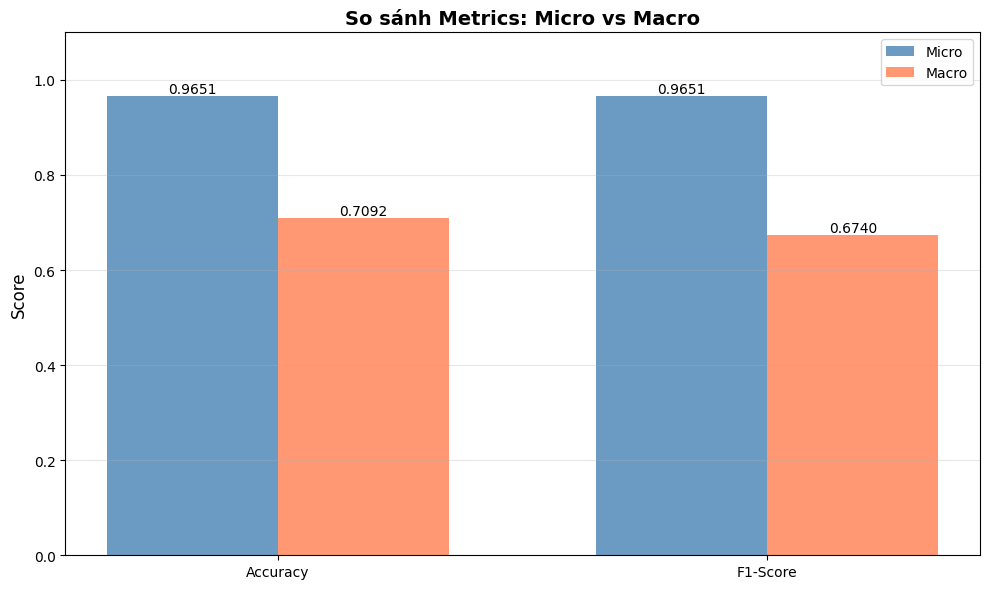

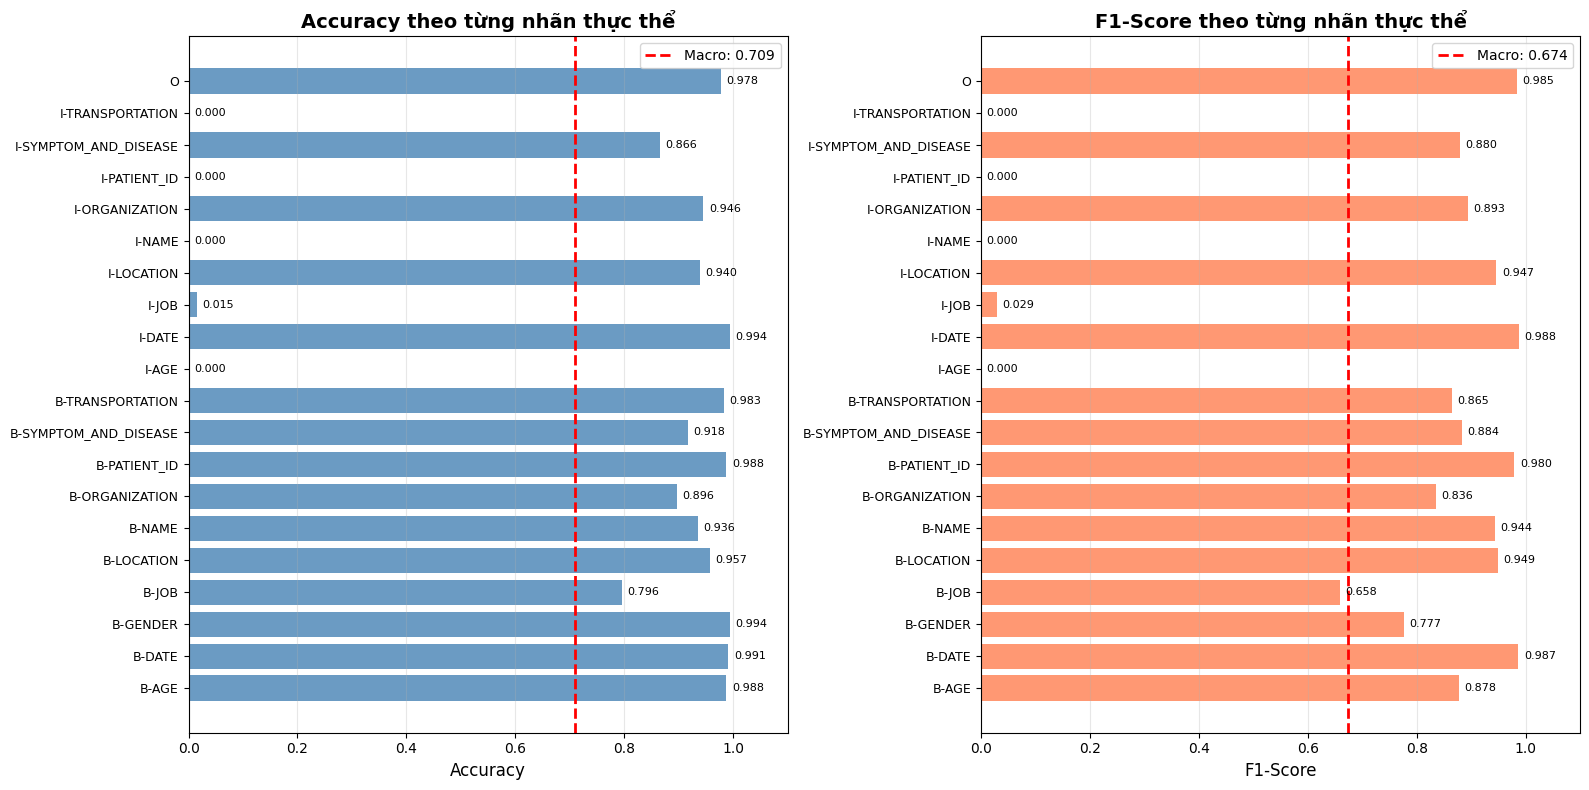

In [17]:
# Visualization: So sánh Micro vs Macro
fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Accuracy', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, [accuracy_micro, f1_micro], width, label='Micro', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, [accuracy_macro, f1_macro], width, label='Macro', alpha=0.8, color='coral')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('So sánh Metrics: Micro vs Macro', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization: Kết quả theo từng tag
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
x_pos = np.arange(len(tag_names))

# Bar chart Accuracy
bars1 = ax1.barh(x_pos, tag_accuracies, alpha=0.8, color='steelblue')
ax1.set_yticks(x_pos)
ax1.set_yticklabels(tag_names, fontsize=9)
ax1.set_xlabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1.1])
ax1.axvline(x=accuracy_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {accuracy_macro:.3f}')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, acc) in enumerate(zip(bars1, tag_accuracies)):
    width = bar.get_width()
    ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Bar chart F1-Score
bars2 = ax2.barh(x_pos, tag_f1_scores, alpha=0.8, color='coral')
ax2.set_yticks(x_pos)
ax2.set_yticklabels(tag_names, fontsize=9)
ax2.set_xlabel('F1-Score', fontsize=12)
ax2.set_title('F1-Score theo từng nhãn thực thể', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.1])
ax2.axvline(x=f1_macro, color='red', linestyle='--', linewidth=2, label=f'Macro: {f1_macro:.3f}')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# Thêm giá trị trên các cột
for i, (bar, f1) in enumerate(zip(bars2, tag_f1_scores)):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{f1:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Bước 7: Lưu model

In [ ]:
torch.save(model.state_dict(), 'transformer_ner_vi_final.pth')